# Интернет-магазин «В один клик»: разработка решения для персонализации предложений постоянным клиентам

## Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений на основе анализа данных и бизнес-моделирования.

**Цель бизнеса**: увеличить покупательскую активность постоянных клиентов.

**Цель проекта**: построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца, выделить сегменты покупателей и разработать для них персонализированные предложения. 

**Задачи проекта**:
1. Промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
2. Нужно собрать данные по клиентам по следующим группам:
- Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
- Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
- Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
- Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.
3. Включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
4. Используя данные модели и данные о прибыльности клиентов, выделить сегменты покупателей и разработать для них персонализированные предложения.

**Описание данных**

Данные для работы находятся в нескольких таблицах. 

1. `market_file.csv` - таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
2. `market_money.csv` - таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
3. `market_time.csv` - таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
4. `money.csv` - таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

**Ход исследования**

1. *Загрузка и проверка данных*.
2. *Предобработка данных*. Работа с пропусками и дубликатами. 
3. *Исследовательский анализ данных*. Отбор клиентов с покупательской активностью не менее трёх месяцев.
4. *Объединение таблиц* market_file.csv, market_money.csv, market_time.csv.
5. *Корреляционный анализ*. 
6. *Создание пайплайнов*. Обработка количественных и категориальных данных, подбор гиперпараметров, лучшей модели и наиболее подходящей метрики.
7. *Анализ важности признаков*. Анализ признаков лучшей модели и построение графика важности с помощью метода SHAP. 
8. *Сегментация покупателей*. Выбор группы покупателей, проведение графического и аналитического исследование группы покупателей и создагие предложения по работе с сегментом для увеличения покупательской активности.
9. *Общий вывод*. Описание задачи, хода исследования, описание лучшей модели и дополнительные предложения для выбранного сегмента покупателей.

## Загрузка и проверка данных

### Импорт библиотек

In [1]:
!pip install phik shap scikit-learn==1.6.0 -q

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from phik import phik_matrix
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    OneHotEncoder,
    StandardScaler,
    LabelEncoder,
    OrdinalEncoder
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

sns.set_theme()

from sklearn.impute import SimpleImputer

### Загрузка и проверка таблиц

#### Поведение покупателей

Загружаем `market_file.csv` - таблицу, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. Сохраняем в переменную `behavior`.

In [3]:
behavior = pd.read_csv('/datasets/market_file.csv')
behavior.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


**Пояснения к данным**:
- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

In [4]:
#переименум столбцы согласно стандартному оформлению
behavior = behavior.rename(
    columns={
        'Покупательская активность': 'activity',
        'Тип сервиса': 'service_type',
        'Разрешить сообщать': 'yes_mailing',
        'Маркет_актив_6_мес': 'marketing_half_year',
        'Маркет_актив_тек_мес': 'marketing_actual',
        'Длительность': 'days_registered',
        'Акционные_покупки': 'promo_buy',
        'Популярная_категория': 'favorite_category',
        'Средний_просмотр_категорий_за_визит': 'categories_count',
        'Неоплаченные_продукты_штук_квартал': 'unpaid_count_quarter',
        'Ошибка_сервиса': 'errors_count',
        'Страниц_за_визит': 'pages_count',
    }
)

In [5]:
behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1300 non-null   int64  
 1   activity              1300 non-null   object 
 2   service_type          1300 non-null   object 
 3   yes_mailing           1300 non-null   object 
 4   marketing_half_year   1300 non-null   float64
 5   marketing_actual      1300 non-null   int64  
 6   days_registered       1300 non-null   int64  
 7   promo_buy             1300 non-null   float64
 8   favorite_category     1300 non-null   object 
 9   categories_count      1300 non-null   int64  
 10  unpaid_count_quarter  1300 non-null   int64  
 11  errors_count          1300 non-null   int64  
 12  pages_count           1300 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 132.2+ KB


In [6]:
behavior.describe()

,id,marketing_half_year,marketing_actual,days_registered,promo_buy,categories_count,unpaid_count_quarter,errors_count,pages_count
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


#### Выручка с покупателей

Загружаем `market_money.csv` - таблицу с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом. Сохраняем в переменную `revenue`.

In [7]:
revenue = pd.read_csv('/datasets/market_money.csv')
revenue.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


**Пояснения к данным**:
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например,
'текущий_месяц' или 'предыдущий_месяц'.
- `Выручка` — сумма выручки за период.

In [8]:
#переименум столбцы согласно стандартному оформлению
revenue = revenue.rename(
    columns={
        'Период': 'period',
        'Выручка': 'revenue'
    }
)

In [9]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   period   3900 non-null   object 
 2   revenue  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [10]:
revenue.describe()

,id,revenue
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


#### Длительность посещения сайта

Загружаем `market_time.csv` - таблицу с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода. Сохраняем данные в переменную `time`.

In [11]:
time = pd.read_csv('/datasets/market_time.csv')
time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


**Пояснения к данным**:
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.

In [12]:
#переименум столбцы согласно стандартному оформлению
time = time.rename(
    columns={
        'Период': 'period',
        'минут': 'minutes'
    }
)

In [13]:
time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       2600 non-null   int64 
 1   period   2600 non-null   object
 2   minutes  2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [14]:
time.describe()

,id,minutes
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


#### Среднемесячная прибыль от покупателя

Загружаем `money.csv` - таблицу с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю. Сохраняем в переменную `profit`.

In [15]:
profit = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
profit.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


**Пояснения к данным**:
- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.

In [16]:
#переименум столбцы согласно стандартному оформлению
profit = profit.rename(
    columns={
        'Прибыль': 'profit'
    }
)

In [17]:
profit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1300 non-null   int64  
 1   profit  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [18]:
profit.describe()

,id,profit
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


#### Загрузка данных: вывод 

<div style="border: 3px solid black; padding: 10px; border-radius: 5px;">
Все загруженные таблицы соответствуют заявленному описанию, данных достаточно для того, чтобы проводить анализ. При анализе общей информации о датасетах можно увидеть, что в каждом из них нет пропусков и используются корректные типы данных. </div>

## Предобработка данных

Так как пропусков в данных нет и все используемые типы данных корректны, в данном шаге мы только обработаем явные и неявные дубликаты.

### Обработка дубликатов

In [19]:
#проверяем датасеты на наличие явных дубликатов
print('Дубликаты в behavior:', behavior.duplicated().sum())
print('Дубликаты в revenue:', revenue.duplicated().sum())
print('Дубликаты в time:', time.duplicated().sum())
print('Дубликаты в profit:', profit.duplicated().sum())

Дубликаты в behavior: 0
Дубликаты в revenue: 0
Дубликаты в time: 0
Дубликаты в profit: 0


**Комментарий**: В датасетах явных дубликатов нет.

**Датасет behavior**

In [20]:
print('Уникальные значения покупательской активности:', ', '.join(behavior['activity'].unique()))

Уникальные значения покупательской активности: Снизилась, Прежний уровень


In [21]:
print('Уникальные значения типов сервиса:', ', '.join(behavior['service_type'].unique()))

Уникальные значения типов сервиса: премиум, стандартт, стандарт


In [22]:
#убираем неявные дубликаты
behavior['service_type'] = behavior.service_type.replace('стандартт', 'стандарт')

In [23]:
print('Уникальные значения в yes_mailing:', ', '.join(behavior['yes_mailing'].unique()))

Уникальные значения в yes_mailing: да, нет


In [24]:
print('Уникальные значения в любимых категориях:', ', '.join(behavior['favorite_category'].unique()))

Уникальные значения в любимых категориях: Товары для детей, Домашний текстиль, Косметика и аксесуары, Техника для красоты и здоровья, Кухонная посуда, Мелкая бытовая техника и электроника


**Датасет time**

In [25]:
print('Уникальные значения в period:', ', '.join(time['period'].unique()))

Уникальные значения в period: текущий_месяц, предыдцщий_месяц


In [26]:
#убираем некорректное написание, чтобы избавиться от дальнейших проблем при объединении датасетов
time['period'] = time.period.replace('предыдцщий_месяц', 'предыдущий_месяц')

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично, молодец, обнаружены 2 "разночтения" (**стандартт** и **предыдцщий_месяц**) - по факту в одних и тех же категориях в признаках.

p.s. но остался ещё один баг: **Косметика и аксеСуары** .... должно быть 2 "с" в слове, не одна.
</div>

### Предобработка данных: вывод

<div style="border: 3px solid black; padding: 10px; border-radius: 5px;">
Все датасеты прошли через предобработку данных: название колонок имеет корректное форматирование, используются корректные типы данных, пропусков и явных дубликатов нет, неявные дубликаты и опечатки в данных были убраны. Так убран неявный дубликат в датасете behavior в столбце service_type и убрана опечатка в датасете time в столбце period. </div>

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

В этом разделе всё ОК: необходимые после загрузки данных действия (1. требования PEP8, 2. дубликаты, 3. анализ уникальных значений в признаках, 4. пропуски) выполнены. Этот вывод результат твоей работы описывает и подъитоживает. Здесь всё супер, молодец!

</div>

## Исследовательский анализ данных

Перед нами стоит задача проанализировать данные в разрезе целевого признака - а это покупательская активность клиентов (снижается она или повышается). Для удобства анализа мы исследуем признаки по следующим группам:
1. **Коммуникация**. Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
2. **Продуктовое поведение**. Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
3. **Финансовое поведение**. Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
4. **Взаимодействие с сайтом**. Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.

### Коммуникация сотрудников с клиентами

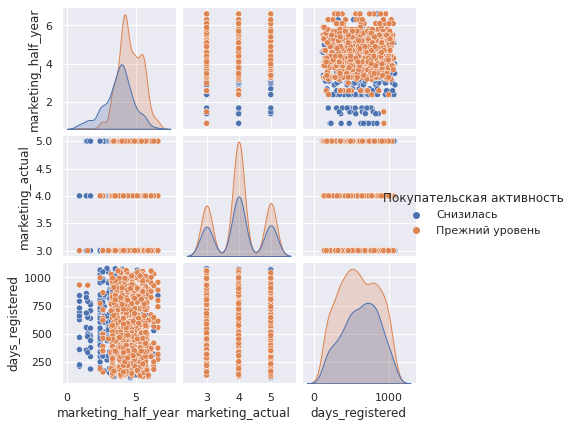

In [27]:
#отбираем столбцы, отвечающие за коммуникацию с клиентом
communication_columns = [
    'service_type',
    'yes_mailing',
    'marketing_half_year',
    'marketing_actual',
    'days_registered',
]
pplot = sns.pairplot(behavior[communication_columns + ['activity']], hue='activity', height=2)

pplot.legend.set(title='Покупательская активность')

plt.show()

**Категориальные признаки в разрезе целевого: рассылка и тип подписки**

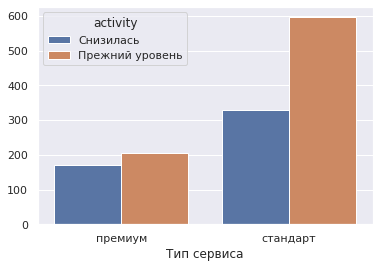

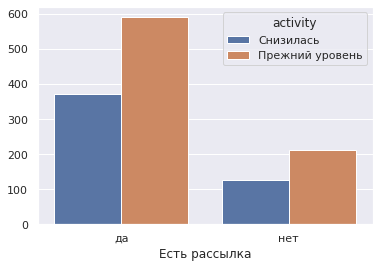

In [28]:
sns.countplot(data=behavior, x='service_type', hue='activity').set(
    xlabel='Тип сервиса', ylabel=None
)
plt.show()

sns.countplot(data=behavior, x='yes_mailing', hue='activity').set(
    xlabel='Есть рассылка', ylabel=None
)
plt.show()

**Выводы:** 
1. По графикам можем увидеть дисбаланс классов: активных клиентов сильно больше, чем тех, у кого активность на последние три месяца снизилась.
2. В стандартной подписке активных клиентов гораздо больше в процентном соотношении, нежели в подписке премиум: почти половина клиентов с премиальной подпиской имеют сниженную активность.
3. Рассылка заметно на активность не влияет, хотя большинство клиентов её имеет.
4. Количество среднемесячных маркетинговых взаимодействий за полгода у активных пользователей смещено правее: чем больше напоминаний клиенту, тем выше его активность.

### Продуктовое поведение клиентов

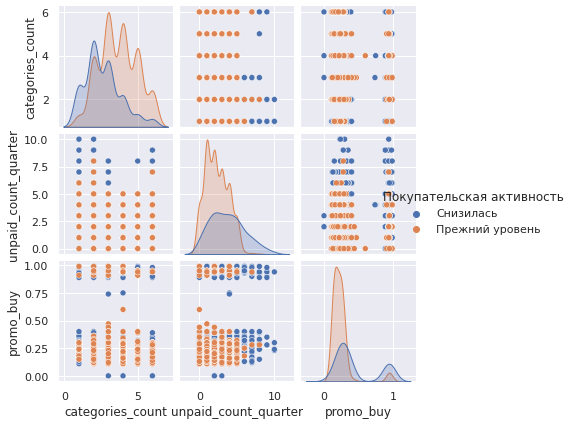

In [29]:
#отбираем столбцы, отвечающие за продуктовое поведение
product_columns = [
    'favorite_category',
    'categories_count',
    'unpaid_count_quarter',
    'promo_buy'
]
pplot = sns.pairplot(behavior[product_columns + ['activity']], hue='activity', height=2)

pplot.legend.set(title='Покупательская активность')

plt.show()

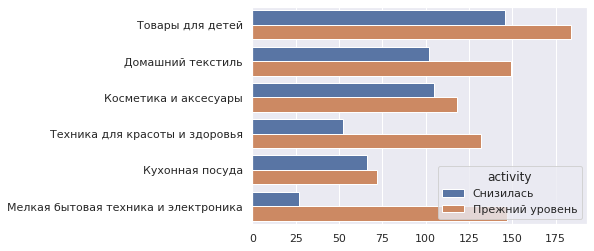

In [30]:
sns.countplot(data=behavior, y='favorite_category', hue='activity').set(
    xlabel=None, ylabel=None
)
plt.show()

**Выводы**:

1. Самая популярная категория и у активных клиентов и неактивных - товары для детей.
2. Категорию "мелкая бытовая техника и электроника" в большинстве случаев покупают активные клиенты.
3. Кухонная посуда практически одинаково продается как у активных, так и у неактивных клиентов.
4. Есть прямая корреляция между активностью клиента и количеством категорий товаров.
5. Обратная корреляция между активностью клиента и количеством неоплаченных товаров: чем активнее клиент, тем их меньше.
6. Активные клиенты все меньше покупают товаров по акции, это более свойственно клиентам, у которых падает активность.

### Финансовое поведение клиентов

In [31]:
#скорректируем изначальную таблицу для удобства анализа
revenue = revenue.pivot(
    index='id',
    columns='period',
    values='revenue',
).rename(
    columns={
        'текущий_месяц': '0revenue_actual_month',
        'предыдущий_месяц': '1revenue_last_month',
        'препредыдущий_месяц': '2revenue_before'
    }
)

revenue = revenue[revenue.columns.sort_values(ascending=False)]
revenue.columns.name = None

,2revenue_before,1revenue_last_month,0revenue_actual_month
count,1300.000000,1300.000000,1300.000000
mean,4825.206923,4936.920385,5314.960846
std,405.979663,739.597997,2939.708156
min,0.000000,0.000000,2758.700000
25%,4583.000000,4496.750000,4706.050000
50%,4809.000000,5005.000000,5179.950000
75%,5053.500000,5405.625000,5761.725000
max,5663.000000,6869.500000,106862.200000


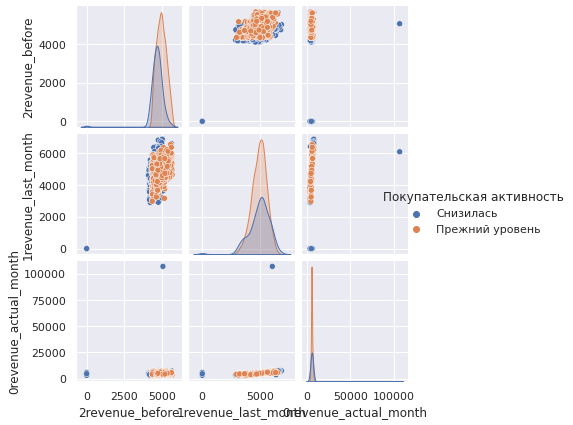

In [32]:
finance_data = pd.merge(behavior, revenue, on='id', how='right')

#отбираем столбцы, отвечающие за финансовое поведение
finance_columns = [
    '2revenue_before',
    '1revenue_last_month',
    '0revenue_actual_month'
]

pplot = sns.pairplot(finance_data[finance_columns + ['activity']], hue='activity', height=2)

pplot.legend.set(title='Покупательская активность')

display(finance_data[finance_columns].describe())
plt.show()

**Комментарий:** В данных очевидно есть аномальные значения и выбросы (нули и значения выше 100 тысяч). Их надо убрать. Так заодно мы уберем тех, кто в последние три месяца не вел никакой покупательской активности (нулевую выручку). 

In [33]:
#убираем выбросы и аномальные значения
finance_data = finance_data[finance_data['0revenue_actual_month'] < 100000]
finance_data = finance_data[finance_data['0revenue_actual_month'] > 0]
finance_data = finance_data[finance_data['1revenue_last_month'] > 0]
finance_data = finance_data[finance_data['2revenue_before'] > 0]
revenue = revenue[revenue['0revenue_actual_month'] < 100000]
revenue = revenue[revenue['0revenue_actual_month'] > 0]
revenue = revenue[revenue['1revenue_last_month'] > 0]
revenue = revenue[revenue['2revenue_before'] > 0]

,2revenue_before,1revenue_last_month,0revenue_actual_month
count,1296.000000,1296.000000,1296.000000
mean,4836.202160,4947.468750,5238.096065
std,333.514091,700.797239,834.318717
min,4098.000000,2890.000000,2758.700000
25%,4584.500000,4498.125000,4706.050000
50%,4810.500000,5005.500000,5179.950000
75%,5056.000000,5405.625000,5759.275000
max,5663.000000,6869.500000,7799.400000


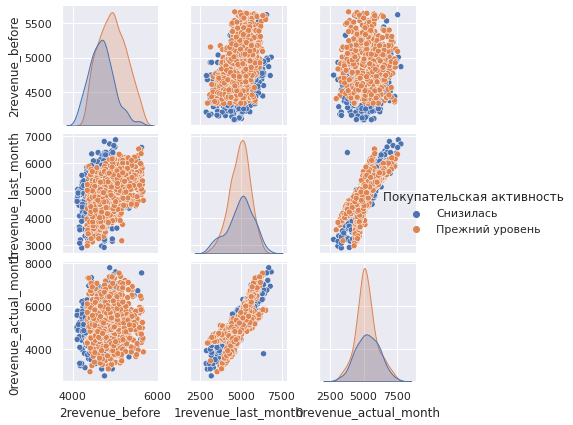

In [34]:
#выводим обновленные корректные данные
pplot = sns.pairplot(finance_data[finance_columns + ['activity']], hue='activity', height=2)

pplot.legend.set(title='Покупательская активность')

display(finance_data[finance_columns].describe())
plt.show()

**Выводы**: 
1. Выручка за предпредыдущий месяц больше от активных клиентов. Видимо, если выручка за предпрошедший месяц всё ниже, это сигнал о снижении активности.
2. Заметно, что выручка больше с активных клиентов, что логично.
   
В целом, выраженного влияния выручки на активность клиента и наоборот нет. 

### Взаимодействие с сайтом

In [35]:
#делаем датасет time более удобным для анализа
time = time.pivot(
    index='id',
    columns='period',
    values='minutes',
).rename(
    columns={
        'текущий_месяц': 'period_actual',
        'предыдущий_месяц': 'period_last',
    }
)

time = time[time.columns.sort_values(ascending=False)]
time.columns.name = None

,period_last,period_actual,pages_count,errors_count
count,1300.000000,1300.000000,1300.000000,1300.000000
mean,13.467692,13.204615,8.176923,4.185385
std,3.932029,4.220589,3.978126,1.955298
min,5.000000,4.000000,1.000000,0.000000
25%,11.000000,10.000000,5.000000,3.000000
50%,13.000000,13.000000,8.000000,4.000000
75%,17.000000,16.000000,11.000000,6.000000
max,23.000000,23.000000,20.000000,9.000000


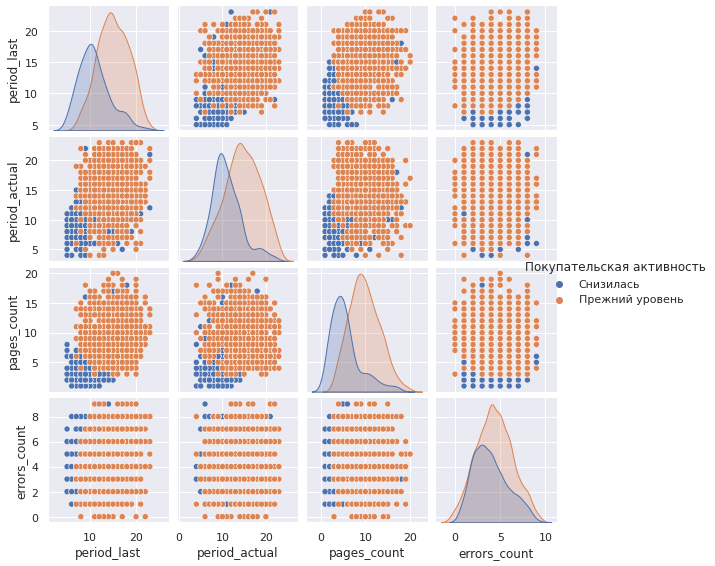

In [36]:
website_data = pd.merge(behavior, time, on='id', how='right')

#отбираем столбцы, отвечающие за поведение на сайте
website_columns = [
    'period_last',
    'period_actual',
    'pages_count',
    'errors_count'
]

pplot = sns.pairplot(website_data[website_columns + ['activity']], hue='activity', height=2)

pplot.legend.set(title='Покупательская активность')

display(website_data[website_columns].describe())
plt.show()

**Выводы**:
1. Прямая корреляция между активностью и количеством просмотренных страниц: клиент больше "листает", выше покупательская активность.
2. Прямая корреляция между активностью и временем на сайте (что в текущем, что в прошедшем периоде): клиент дольше на сайте, выше покупательская активность.
3. Количество ошибок существенно на активность не влияет.

### Исследовательский анализ данных: вывод

<div style="border: 3px solid black; padding: 10px; border-radius: 5px;">
По графикам можем увидеть дисбаланс классов: активных клиентов сильно больше, чем тех, у кого активность на последние три месяца снизилась.
    
1. **Коммуникация**.
    - В стандартной подписке активных клиентов гораздо больше в процентном соотношении, нежели в подписке премиум: почти половина клиентов с премиальной подпиской имеют сниженную активность.
    - Рассылка заметно на активность не влияет, хотя большинство клиентов её имеет.
    - Количество среднемесячных маркетинговых взаимодействий за полгода у активных пользователей смещено правее: чем больше напоминаний клиенту, тем выше его активность.
      
      
2. **Продуктовое поведение.**
    - Самая популярная категория и у активных клиентов и неактивных - товары для детей.
    - Категорию "мелкая бытовая техника и электроника" в большинстве случаев покупают активные клиенты.
    - Кухонная посуда практически одинаково продается как у активных, так и у неактивных клиентов.
    - Есть прямая корреляция между активностью клиента и количеством категорий товаров.
    - Обратная корреляция между активностью клиента и количеством неоплаченных товаров: чем активнее клиент, тем их меньше.
    - Активные клиенты все меньше покупают товаров по акции, это более свойственно клиентам, у которых падает активность.
5. **Финансовое поведение.** 
    - Выраженной корреляции между активностью и выручкой нет, но выручка больше с активных клиентов, что логично.
    - Выручка за предпредыдущий месяц больше от активных клиентов. Видимо, если выручка за предпрошедший месяц всё ниже, это сигнал о снижении активности.
6. **Взаимодействие с сайтом.** 
    - Прямая корреляция между активностью, количеством просмотренных страниц и временем на сайте: чем дольше клиент на сайте и "глубже" в него проваливается, тем больше делает покупок.
    - Количество ошибок сайта существенно на активность не влияет.</div>

## Объединение датасетов

В этом шаге мы объединим три датасета: behavior, revenue, time. Прежде чем объединять датасеты, необходимо узнать их размерность. 

In [37]:
print('Размерность датасета behavior:', behavior.shape)
print('Размерность датасета time:', time.shape)
print('Размерность датасета revenue:', revenue.shape)

Размерность датасета behavior: (1300, 13)
Размерность датасета time: (1300, 2)
Размерность датасета revenue: (1296, 3)


**Комментарий**: В датасете revenue, очевидно, есть пропуски, так как мы удаляли аномальные и нулевые значения. Так как пропусков незначительное количество, мы можем объединить датасеты методом outer и после удалить строки с пропусками, данных для анализа останется достаточно.

In [38]:
data = behavior.merge(revenue, on='id', how='outer') \
                      .merge(time, on='id', how='outer')

data = data.dropna()

display(data.head())

,id,activity,service_type,yes_mailing,marketing_half_year,marketing_actual,days_registered,promo_buy,favorite_category,categories_count,unpaid_count_quarter,errors_count,pages_count,2revenue_before,1revenue_last_month,0revenue_actual_month,period_last,period_actual
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10


<div style="border: 3px solid black; padding: 10px; border-radius: 5px;"> 

**Вывод**: 

При объединении датасетов были убраны строки с аномальными и нулевыми значениями датасета revenue, поэтому наблюдений стало меньше: 1296.
    </div>

## Корреляционный анализ

На данном этапе мы проведем корреляционый анализ количественных признаков, прежде чем готовить модель, так как есть риск мультиколлинеарности признаков, который надо предупредить и устранить. При исследовательском анализе данных мы увидели, что не все входные признаки имеют нормальное распределение, поэтому уместно будет использование при построении матрицы корреляции коэффициента Кендалла. 

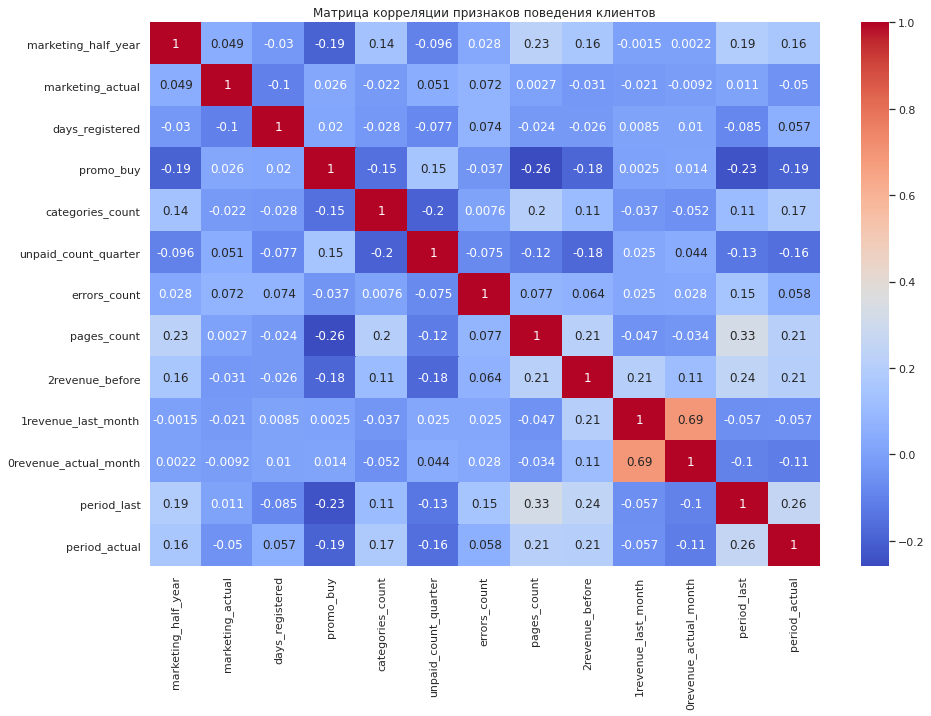

In [39]:
numeric_data = data.select_dtypes(include=[float, int]).drop(columns=['id'])
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(data=numeric_data.corr(method='kendall'), annot=True, cmap='coolwarm').set(title='Матрица корреляции признаков поведения клиентов')
plt.show()

<div style="border: 3px solid black; padding: 10px; border-radius: 5px;"> 

**Вывод:** 

На этой матрице можно наблюдать относительно других признаков более высокое значение корреляции между признаками выручки за прошлый месяц и за текущий: 0.69. Но коллинеарностью это не является, так как на самом деле по сути эти факторы друг от друга не зависят и никак друг друга не определяют. Эта линейность в любой момент может быть нарушена. В остальном мультиколлинеарности нет, устранять её нет необходимости.
    </div>

## Разработка модели на основе пайплайнов

### Подготовка данных

Подготовим данные с признаками, а также закодируем целевой. Уберем признак id так как он лишний при обучении.

In [40]:
features = data.drop(columns=['id', 'activity'])
target = data['activity']

#обучение LabelEncoder
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(target)

#выводим преобразованные значения для проверки
print("Преобразованные значения:", target)

Преобразованные значения: [1 1 1 ... 0 0 0]


Для подготовки данных создадим пайплайн с использованием ColumnTransformer. Количественные и категориальные данные обработаем в пайплайне раздельно.

In [41]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

#готовим выборки
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=target,
)

In [42]:
#делим признаки на количественные и категориальные
cat_columns = ['service_type', 'yes_mailing', 'favorite_category']
ohe_columns = ['yes_mailing', 'favorite_category']
ord_columns = ['service_type']

num_columns = [
    'marketing_half_year',
    'marketing_actual',
    'days_registered',
    'promo_buy',
    'categories_count',
    'unpaid_count_quarter',
    'errors_count',
    'pages_count',
    '2revenue_before',
    '1revenue_last_month',
    '0revenue_actual_month',
    'period_last',
    'period_actual'
]

In [43]:
#создаем пайплайн для кодирования категориальных признаков 
ohe_pipe = Pipeline(
    [
        ('ohe', 
         OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [
        ('ord',
        OrdinalEncoder())
    ]
)

#объединяем шаги подготовки данных в пайплайн
data_preprocessing = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

#итоговый пайплайн
pipe_final =  Pipeline(
    [
        ('preprocessor', data_preprocessing),
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

### Выбор лучшей модели

Мы создадим сетку параметров для поиска лучшей модели из четырёх: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(), SVC(). Для каждой модели подберем как минимум один гиперпараметр. Масштабируем данные двумя методами, выберем лучший. 

In [44]:
#создаем словарь со значениями гиперпараметров
param_grid = [
     {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3, 11, 2),
        'models__p': [1, 2],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],  
    },
    {
        'models': [DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__min_samples_split':range(2, 5),
        'models__min_samples_leaf': range(1, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },
    {
        'models': [LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)],
        'models__penalty': ['l1', 'l2'],
        'models__C': range(1, 5),
        'models__solver': ['liblinear', 'saga'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },
    {
        'models': [SVC(kernel='linear', class_weight='balanced')],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },
]

**Комментарий**: в качестве метрики мы будем использовать ROC-AUC. В данном случае мы используем именно эту метрику, так как ROC-AUC не зависит от распределения классов (в нашем случае есть дисбаланс классов) и учитывает все возможные пороги.

In [45]:
#перебираем модели и их параметры
grid = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid.fit(X_train, y_train)

predictions = grid.predict(X_test)
probas = grid.predict_proba(X_test)

In [46]:
print('Лучшая модель:')
grid.best_estimator_

Лучшая модель:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['yes_mailing',
                                                   'favorite_category']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder())]),
                                                  ['service_type']),
                                                 ('num', MinMaxScaler(),
                                                  ['marketing_half_year',
                                                   'marketing_actual',
                                                   'days_registered',
                                                   'promo_buy',
                                                   'categories_count',
                                                   'unpaid_count_quarter',
                                                   'errors_count',
                                                   'pages_count',
                                                   '2revenue_before',
                                                   '1revenue_last_month',
                                                   '0revenue_actual_month',
                                                   'period_last',
                                                   'period_actual'])])),
                ('models',
                 LogisticRegression(C=1, class_weight='balanced',
                                    random_state=42, solver='saga'))])

**Комментарий**: Лучше всех справляется модель LogiscticRegression с масштабированием MinMaxScaler!

### Оценка метрик лучшей модели

In [47]:
print('Показатель ROC-AUC:', roc_auc_score(y_test, probas[:, 1]))

Показатель ROC-AUC: 0.9184969461634914


**Комментарий**: Показатель ROC-AUC говорит о том, что модель очень хорошо различает классы, показатель довольно высок - 0.918.

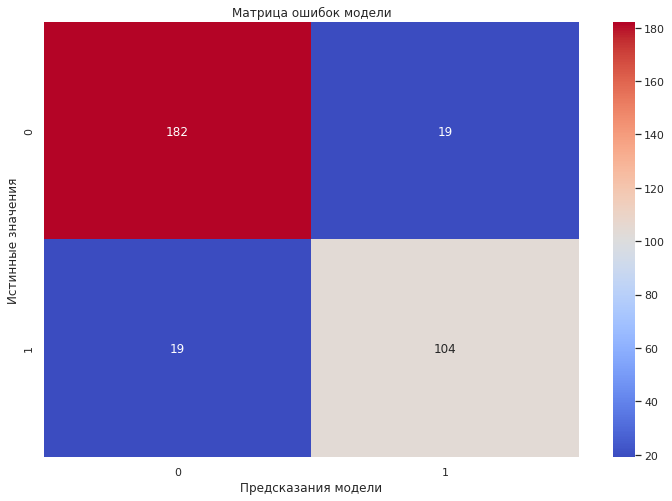

In [48]:
cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(cm, annot=True, fmt='.0f', cmap='coolwarm', ax=ax).set(
    title='Матрица ошибок модели',
    xlabel='Предсказания модели',
    ylabel='Истинные значения',
)

plt.show()

In [49]:
print('Accuracy:', round(accuracy_score(y_test, predictions), 2))
print('Precission:', round(precision_score(y_test, predictions), 2))
print('Recall:', round(recall_score(y_test, predictions), 2))
print('F1:', round(f1_score(y_test, predictions), 2))

Accuracy: 0.88
Precission: 0.85
Recall: 0.85
F1: 0.85


**Комментарий**: По матрице ошибок и показателям Precission, Recall и F1 мы видим, что модель в равной степени делает ошибки первого и второго рода. Так как ошибок мало и показатель качества высок, то упущенная выгода от "пропущенных" со сниженной активностью клиентов не так критична.

### Разработка модели : выводы

<div style="border: 3px solid black; padding: 10px; border-radius: 5px;"> 

    
- Мы создадили сетку параметров для поиска лучшей модели из четырёх: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(), SVC(). Для каждой модели подобрали как минимум один гиперпараметр, масштабировали данные двумя методами.
- Наиболее подходящей для нашей задачи оказалась модель **LogiscticRegression с масштабированием MinMaxScaler**.
- Показатель метрики ROC-AUC для этой модели довольно высок - 0.918. В данном случае мы используем именно эту метрику, так как ROC-AUC не зависит от распределения классов и учитывает все возможные пороги.
- По матрице ошибок и показателям Precission (0.85), Recall(0.85) и F1(0.85) мы видим, что модель в равной степени делает ошибки первого и второго рода, то есть одинаково часто ошибается при определении активных и неактивных клиентов.
    </div>

## Анализ важности признаков

В данном шаге мы оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP. Это поможет понять, какие признаки мало значимы для модели, какие признаки сильнее всего влияют на целевой признак и как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.

### Влияние признаков. Построение SHAP

In [50]:
#извлекаем имена признаков после кодировки из предобработки preprocessor
ohe_columns_cod = list(grid.best_estimator_['preprocessor']['ohe'].get_feature_names_out())
ord_columns_cod = list(grid.best_estimator_['preprocessor']['ord'].get_feature_names_out())

#создаем полный список признаков, объединив имена закодированных категориальных и числовых признаков
columns = ohe_columns_cod + ord_columns_cod + num_columns

#преобразуем входные признаки с помощью конвейера предобработки лучшей модели
input_features = grid.best_estimator_[0].transform(features)

In [51]:
#создаем объект для интерпретации модели, передаем модель, входные признаки и их имена
explainer = shap.LinearExplainer(grid.best_estimator_[1], input_features, feature_names=columns)
#вычисляем SHAP
shap_values = explainer(input_features)

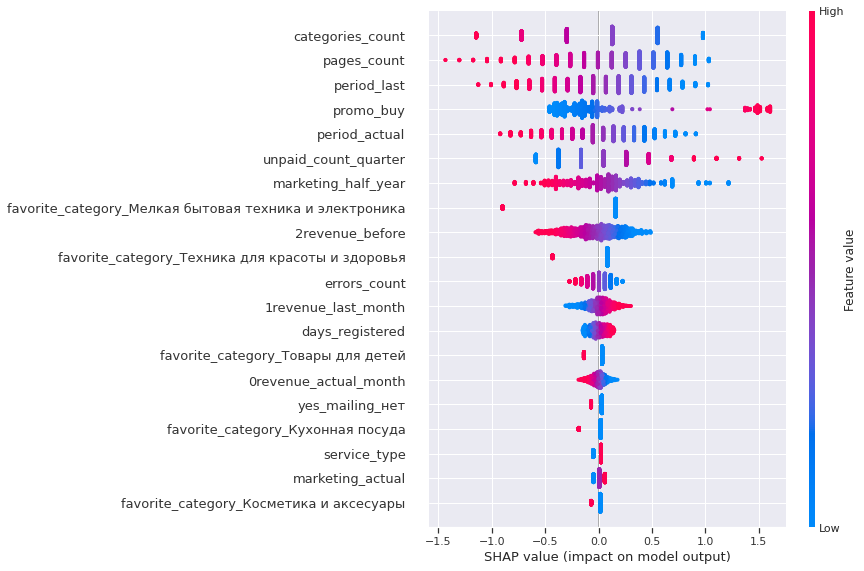

In [52]:
shap.plots.beeswarm(shap_values, max_display=None)

### Влияние признаков: выводы

<div style="border: 3px solid black; padding: 10px; border-radius: 5px;"> 

1. **Признаки, которые мало значимы для модели**. Среди таких можем выделить следующие:
    - актуальные маркетинговые действия (вероятно, их эффект мы узнаем позже);
    - наличие рассылки;
    - выручка с клиента за текущий месяц;
    - тип подписки.
    

2. **Признаки, которые сильнее всего влияют на целевой признак**. Среди них можем выделить те, высокий показатель которых приводит к тому, что модель с высокой вероятностью отнесет пользователя к классу 0 (активный):
    - количество приобретаемых категорий;
    - количество просмотренных страниц;
    - время пребывания на сайте в прошлом месяце;
    - уровень маркетинговых действий за последние полгода.
    
В качестве обратных признаков, сильно влияющих на отнесение к классу 1 (неактивный), при их росте:
    
    - наличие акционных покупок;
    - количество неоплаченных товаров.
    
3. **Как можно использовать эти наблюдения при моделировании и принятии бизнес-решений?** На основе этих выводов можно:
    - зафиксировать портреты активного и неактивного покупателя: активный делает покупки в разных категориях, проводит много времени на сайте и "глубоко" в него проваливается, а неактивный часто имеет больше неоплаченных товаров и акционных покупок;
    - обратить внимание на важность маркетинговых коммуникаций: чем их больше, чем выше активность клиента;
    - делать меньше ставки на рассылку и формат подписки - их корреляция с активностью очень низкая.
   
    </div>

## Анализ сегмента

### Выбор и выделение сегмента

В данном шаге мы проанализируем группу клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности. Эта группа наиболее интересна для анализа, так как наличие акционных покупок, как мы выяснили раннее, сильно влияет на определение снижения активности клиента. 

Анализ этой группы с большой вероятностью поможет принять полезные решения для достижений цели бизнеса: увеличить покупательскую активность постоянных клиентов. В ходе анализа можно узнать особенности продуктового поведения этой группы, чтобы понять, как повысить её активность. 

В первую очередь подготовим данные для анализа этого сегмента.

In [53]:
#добавляем в общий датасет данные о классах и вероятности отнесения: так мы сможем выделить "акционщиков" с низкой активностью
data['predicted'] = grid.predict(features)
data['proba'] = grid.predict_proba(features)[:, 1]

In [54]:
#в качестве "акционщиков" выделим тех клиентов, у которых доля акционных покупок больше половины
promo_client = data['promo_buy'] >= 0.5

#в качестве "неактивных" выделим тех, у которых вероятность получения класса 1 выше 0.5
unactive_client = data['proba'] >= 0.5

In [55]:
#категоризируем этот сегмент новым столбцом
data['unactive_promo'] = np.where(promo_client & unactive_client, 'Да', 'Нет')

### Исследовательский анализ сегмента

#### Коммуникации

Так как по предыдущему анализу мы выяснили, что из всех признаков, которые относятся к категории "коммуникации с клиентом" действительно имеет влияние только один, количество маркетинговых действий за последние полгода, то его мы и проанализируем в выбранном сегменте. 

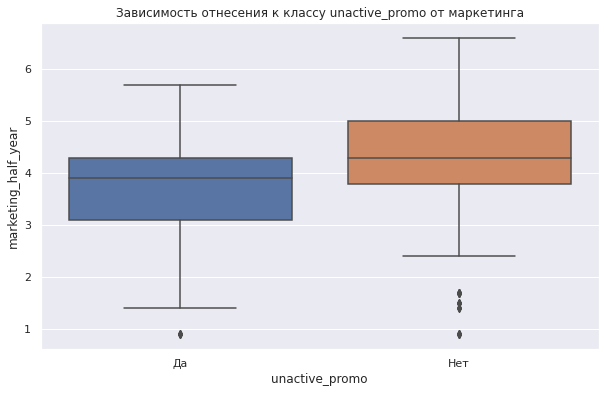

In [56]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='unactive_promo', y='marketing_half_year', data=data)
plt.title('Зависимость отнесения к классу unactive_promo от маркетинга')
plt.xlabel('unactive_promo')
plt.ylabel('marketing_half_year')
plt.show()

**Комментарий:** По графику мы видим наши предыдущие наблюдения: маркетинговые коммуникации действительно в перспективе влияют и на выбранный нами сегмент. Меньше коммуникаций - больше вероятность попадания клиента в группу "акционщиков" с низкой активностью.

#### Продуктовое поведение

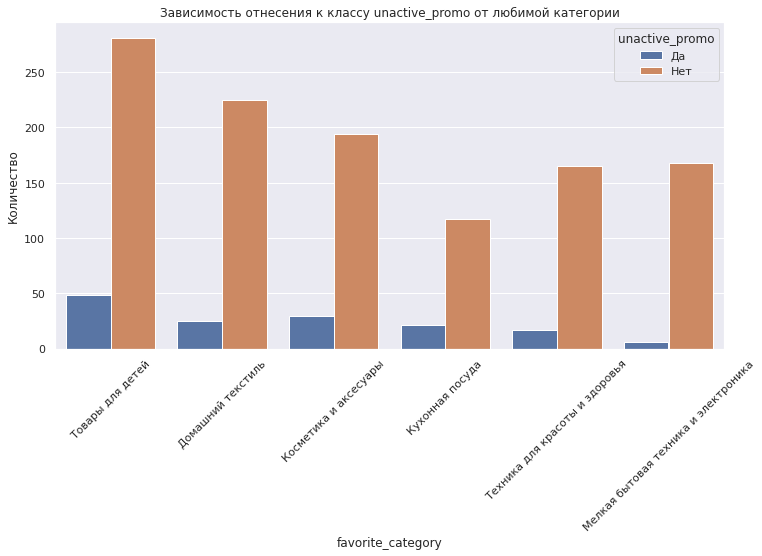

In [57]:
plt.figure(figsize=(12, 6))
sns.countplot(x='favorite_category', hue='unactive_promo', data=data)
plt.title('Зависимость отнесения к классу unactive_promo от любимой категории')
plt.xlabel('favorite_category')
plt.ylabel('Количество')
plt.legend(title='unactive_promo')
plt.xticks(rotation=45)
plt.show()

**Комментарий**: Можем заметить, что в выбранный нами сегмент с большей вероятностью могут попасть те клиенты, которые приобретают товары в категории "Товары для детей", "Косметика и аксесуары". С гораздо меньшей вероятностью - "Мелкая бытовая техника и электроника". 

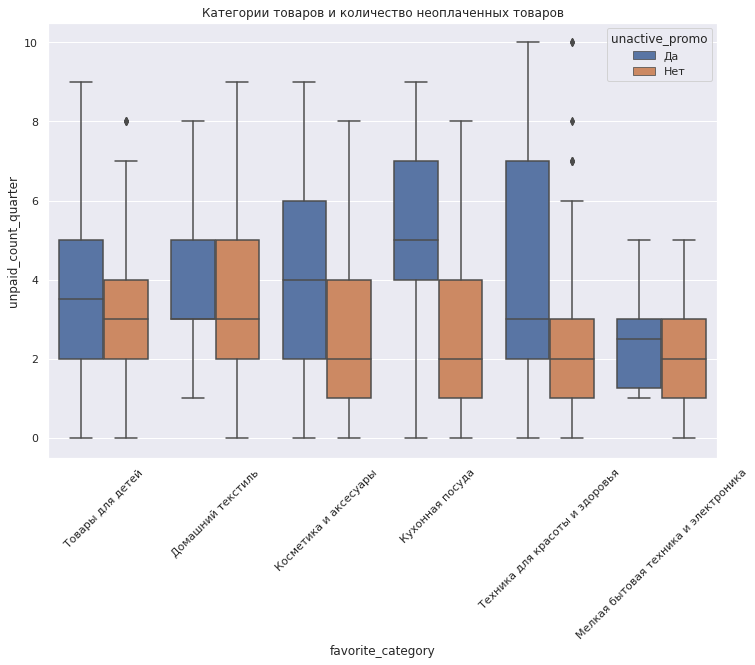

In [58]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='favorite_category', y='unpaid_count_quarter', hue='unactive_promo', data=data)
plt.title('Категории товаров и количество неоплаченных товаров')
plt.xlabel('favorite_category')
plt.ylabel('unpaid_count_quarter')
plt.xticks(rotation=45)
plt.legend(title='unactive_promo')
plt.show()

**Комментарий**: Больше всего "акционщики" не оплачивают кухонную посуду, технику для красоты и здоровья, косметику и аксессуары. Но более ответственно наравне с активными клиентами подходят к оплате мелкой бытовой техники и электроники. 

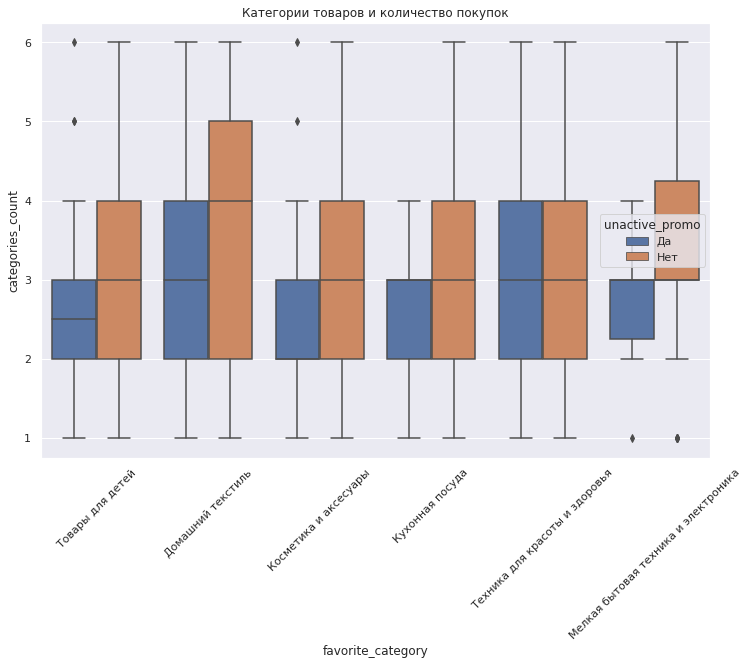

In [59]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='favorite_category', y='categories_count', hue='unactive_promo', data=data)
plt.title('Категории товаров и количество покупок')
plt.xlabel('favorite_category')
plt.ylabel('categories_count')
plt.xticks(rotation=45)
plt.legend(title='unactive_promo')
plt.show()

**Комментарий**: "Акционщики" с низкой активностью заметно меньше, чем активные клиенты, скупают товаров в категории "Мелкая бытовая техника и электроника" (разброс меньше). С большой вероятностью, если такие клиенты ищут выгоду, то они просто находят более выгодные цены на товары этой категории в других магазинах. Небольшой разброс в количестве и среди товаров в категории "Товары для детей", "Косметика и аксессуары", "Кухонная посуда", по сравнению с активными клиентами. Наравне с активными клиентами "акционщики" покупают технику для красоты и здоровья. 

#### Финансовое поведение

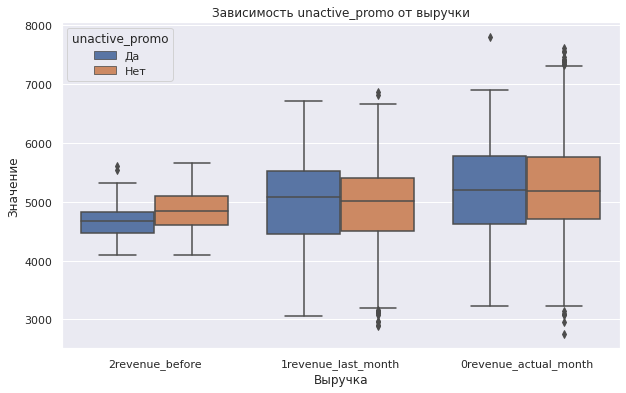

In [60]:
df_melted = data.melt(
    id_vars='unactive_promo', 
    value_vars=['2revenue_before', '1revenue_last_month', '0revenue_actual_month'],
    var_name='Выручка',
    value_name='Значение'
)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Выручка', y='Значение', hue='unactive_promo', data=df_melted)
plt.title('Зависимость unactive_promo от выручки')
plt.xlabel('Выручка')
plt.ylabel('Значение')
plt.legend(title='unactive_promo')
plt.show()

**Комментарий**: по выручке текущей и прошлого месяца отнесение к сегменту определить сложно, но вот по выручке за позапрошлый месяц можно увидеть, что чем она меньше, тем, вероятнее, клиент свою активность снизит и начнет больше покупать по акции. 

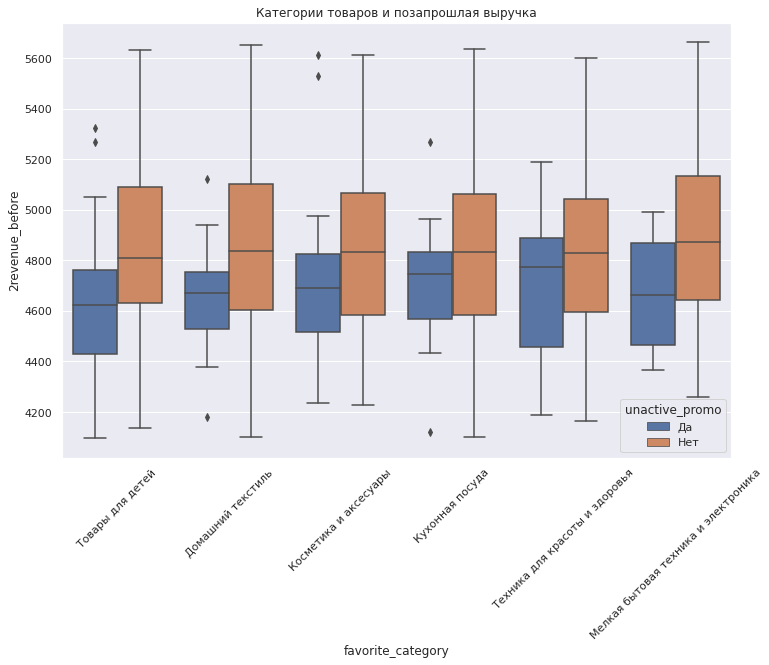

In [61]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='favorite_category', y='2revenue_before', hue='unactive_promo', data=data)
plt.title('Категории товаров и позапрошлая выручка')
plt.xlabel('favorite_category')
plt.ylabel('2revenue_before')
plt.xticks(rotation=45)
plt.legend(title='unactive_promo')
plt.show()

**Комментарий**: Больше всего выручки с "акционщиков" можно получить в сегменте техниики для красоты и здоровья и кухонной посуды. 

#### Взаимодействие с сайтом

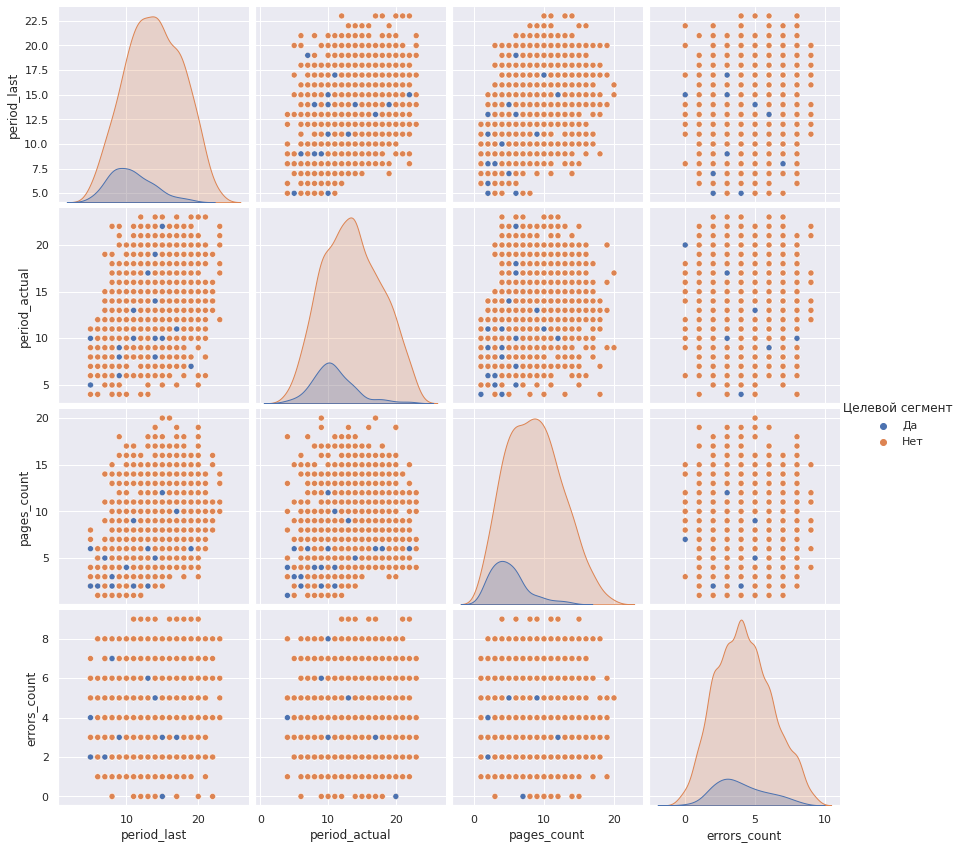

In [62]:
pplot = sns.pairplot(data[website_columns + ['unactive_promo']], hue='unactive_promo', height=3)

pplot.legend.set(title='Целевой сегмент')

plt.show()

**Комментарий**: Что и не требовалось доказывать: "акционщики" меньше проводят времени на сайте ине так "глубоко" в него проваливаются. Вероятно, они сразу переходят в акционные разделы и рассматривают товары только там.

Можем посмотреть на взаимодействие "акционщиков" с сайтом в разрезе приобретаемых товарных категорий.

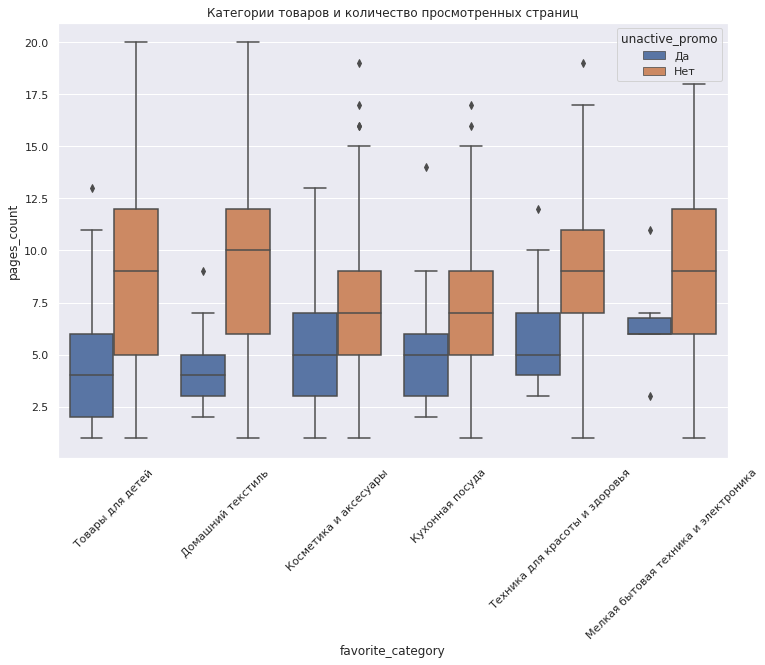

In [63]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='favorite_category', y='pages_count', hue='unactive_promo', data=data)
plt.title('Категории товаров и количество просмотренных страниц')
plt.xlabel('favorite_category')
plt.ylabel('pages_count')
plt.xticks(rotation=45)
plt.legend(title='unactive_promo')
plt.show()

**Комментарий**: Больше всего страниц просматривается в категории "Мелкая бытовая техника": вероятно, клиенты сравнивают товары перед серьезной покупкой (и, вероятно, ищут акции).

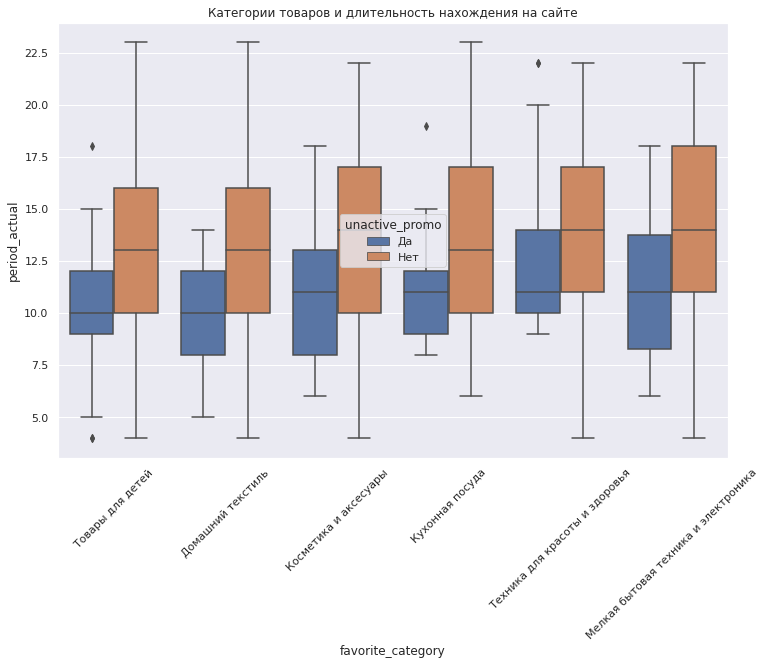

In [64]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='favorite_category', y='period_actual', hue='unactive_promo', data=data)
plt.title('Категории товаров и длительность нахождения на сайте')
plt.xlabel('favorite_category')
plt.ylabel('period_actual')
plt.xticks(rotation=45)
plt.legend(title='unactive_promo')
plt.show()

**Комментарий**: В целом по медианным значениям принципиальной разницы нет между просмотром разных категорий товаров.

### Анализ сегмента: выводы

<div style="border: 3px solid black; padding: 10px; border-radius: 5px;"> 

1. **Коммуникации**. Чем меньше маркетинговых действий, тем вероятнее клиент перейдет в сегмент покупателей с низкой активностью и скупающих товары по акции.
    
    
2. **Продуктовое поведение**. 
    - В выбранный нами сегмент с большей вероятностью могут попасть те клиенты, которые приобретают товары в категории "Товары для детей", "Косметика и аксесуары". С гораздо меньшей вероятностью - "Мелкая бытовая техника и электроника".
    - Чаще всего "акционщики" не оплачивают кухонную посуду, технику для красоты и здоровья, косметику и аксессуары. Но более ответственно наравне с активными клиентами подходят к оплате мелкой бытовой техники и электроники.
    - "Акционщики" с низкой активностью заметно меньше, чем активные клиенты, скупают товаров в категории "Мелкая бытовая техника и электроника". С большой вероятностью, если такие клиенты ищут выгоду, то они просто находят более выгодные цены на товары этой категории в других магазинах. Небольшой разброс в количестве и среди товаров в категории "Товары для детей", "Косметика и аксессуары", "Кухонная посуда", по сравнению с активными клиентами. Наравне с активными клиентами "акционщики" покупают технику для красоты и здоровья.

    
3. **Финансовое поведение.** 
    - По выручке текущей и прошлого месяца отнесение к сегменту определить сложно, но вот по выручке за позапрошлый месяц можно увидеть, что чем она меньше, тем, вероятнее, клиент свою активность снизит и начнет больше покупать по акции.
    - Выручка на текущий момент с "акционных" клиентов сопоставима с выручкой от активных.
    - Больше всего выручки с "акционщиков" можно получить в сегменте техниики для красоты и здоровья и кухонной посуды.
    
    
4. **Взаимодействие с сайтом.**
    - "Акционщики" меньше проводят времени на сайте и не так "глубоко" в него проваливаются. Вероятно, они сразу переходят в акционные разделы и рассматривают товары только там.
    - Больше всего страниц просматривается в категории "Мелкая бытовая техника": вероятно, клиенты сравнивают товары перед серьезной покупкой (и, вероятно, ищут акции).
    - В целом по медианным значениям принципиальной разницы нет между временем просмотра разных категорий товаров.
   
    </div>

## Общий вывод

<div style="border: 1px solid black; padding: 10px; border-radius: 5px;"> 

**Задача проекта**
   
Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца, выделить сегменты покупателей и разработать для них персонализированные предложения.
    </div>

<div style="border: 1px solid black; padding: 10px; border-radius: 5px;"> 

**Исходные данные и их предобработка**

В качестве исходных данных были следующие датасеты:
- `market_file.csv` - таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- `market_money.csv` - таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- `market_time.csv` - таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- `money.csv` - таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

Данных для анализа было достаточно. В датасеха нет пропусков, явных дубликатов, используются корректные типы данных. При предобработке были убраны неявные дубликаты, опечатки, скорректировано оформление названий столбцов. 
    </div>

<div style="border: 1px solid black; padding: 10px; border-radius: 5px;"> 

**Исследовательские анализы данных. Влияние признаков**

1. Зафиксированы портреты активного и неактивного покупателя: 
    - активный делает покупки в разных категориях, проводит много времени на сайте и "глубоко" в него проваливается.
    - неактивный часто имеет больше неоплаченных товаров и акционных покупок.
2. Заметна важность маркетинговых коммуникаций: чем их больше, чем выше активность клиента.
3. Можно делать меньше ставки на рассылку и формат подписки - их корреляция с активностью очень низкая.
    </div>

<div style="border: 1px solid black; padding: 10px; border-radius: 5px;"> 

**Разработка модели** 
    
- Мы создадили сетку параметров для поиска лучшей модели из четырёх: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(), SVC(). Для каждой модели подобрали как минимум один гиперпараметр, масштабировали данные двумя методами.
- Наиболее подходящей для нашей задачи оказалась модель **LogiscticRegression с масштабированием MinMaxScaler**.
- Показатель метрики ROC-AUC для этой модели довольно высок - 0.918. В данном случае мы используем именно эту метрику, так как ROC-AUC не зависит от распределения классов и учитывает все возможные пороги.
- По матрице ошибок и показателям Precission (0.85), Recall(0.85) и F1(0.85) мы видим, что модель в равной степени делает ошибки первого и второго рода, то есть одинаково часто ошибается при определении активных и неактивных клиентов.
   
    </div>

<div style="border: 1px solid black; padding: 10px; border-radius: 5px;"> 

**Анализ сегмента**

В данном шаге мы проанализировали группу клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности. 

Выводы:
- Чем меньше маркетинговых действий, тем вероятнее клиент перейдет в сегмент покупателей с низкой активностью и скупающих товары по акции.
- Чаще всего "акционщики" не оплачивают кухонную посуду, технику для красоты и здоровья, косметику и аксессуары. Но более ответственно наравне с активными клиентами подходят к оплате мелкой бытовой техники и электроники.
- "Акционщики" с низкой активностью заметно меньше, чем активные клиенты, скупают товаров в категории "Мелкая бытовая техника и электроника". С большой вероятностью, если такие клиенты ищут выгоду, то они просто находят более выгодные цены на товары этой категории в других магазинах. 
- Выручка на текущий момент с "акционных" клиентов сопоставима с выручкой от активных. Больше всего выручки с "акционщиков" можно получить в сегменте техниики для красоты и здоровья и кухонной посуды.
- "Акционщики" меньше проводят времени на сайте и не так "глубоко" в него проваливаются. Вероятно, они сразу переходят в акционные разделы и рассматривают товары только там.
- Больше всего страниц просматривается в категории "Мелкая бытовая техника": вероятно, клиенты сравнивают товары перед серьезной покупкой.
    </div>

<div style="border: 3px solid black; padding: 10px; border-radius: 5px;"> 

**ИТОГОВЫЕ РЕКОМЕНДАЦИИ ДЛЯ БИЗНЕСА**
   1. Делать меньше ставки на рассылку и формат подписки - их корреляция с активностью очень низкая.
   2. Повышать количество маркетинговых действих для клиентов с низкой активностью: есть прямая корреляция между плотностью маркетинговой коммуникации и активностью.
   3. Обратить внимание на товары категории "Мелкая бытовая техника и электроника". В этой категории покупатели с низкой активностью и большой долей покупок по акции "задерживаются" меньше всего. С большой вероятностью, если такие клиенты ищут выгоду, то они просто находят более выгодные цены на товары этой категории в других магазинах.
   4. Повышать заинтересованность покупателя в других категориях: возможно, предлагать смежные / сопутствующие товары, чтобы удержать его интерес.
    </div>